In [150]:
import gym
import gym_flp
import matplotlib.pyplot as plt
import os
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import matplotlib.animation as animation
import datetime
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from stable_baselines3.common.vec_env import VecEnv, VecTransposeImage, DummyVecEnv
import imageio
from PIL import Image

In [151]:
instance = 'P6'
timestamp = datetime.datetime.now().strftime("%y%m%d_%H%M")
environment = 'ofp'
algo = 'ppo'
mode = 'rgb_array'
train_steps = np.append(np.outer(10.0**(np.arange(4, 6)), np.arange(1,10,1)).flatten(), 10**6)
train_steps = 1e6
vec_env = make_vec_env('ofp-v0', env_kwargs={'mode': mode, "instance":instance}, n_envs=1)
wrap_env = VecTransposeImage(vec_env)

vec_eval_env = make_vec_env('ofp-v0', env_kwargs={'mode': mode, "instance":instance}, n_envs=1)
wrap_eval_env = VecTransposeImage(vec_eval_env)

In [152]:
save_path = f"{timestamp}_{instance}_{algo}_{mode}_{environment}_movingavg_nocollisions_{str(train_steps)}"

In [153]:
eval_callback = EvalCallback(wrap_eval_env ,
                             best_model_save_path=f'./models/best_model/{save_path}',
                             log_path='./logs/',
                             eval_freq=10000,
                             deterministic=True,
                             render=False,
                             n_eval_episodes = 10)

In [154]:
model = PPO("CnnPolicy",
                vec_env,
                learning_rate=0.0003,
                n_steps=2048,
                batch_size=2048,
                n_epochs=10,
                gamma=0.99,
                gae_lambda=0.95,
                clip_range=0.2,
                clip_range_vf=None,
                ent_coef=0.0,
                vf_coef=0.5,
                max_grad_norm=0.5,
                use_sde=False,
                sde_sample_freq=- 1,
                target_kl=None,
                tensorboard_log=f'logs/{save_path}',
                create_eval_env=False,
                policy_kwargs=None,
                verbose=1,
                seed=None,
                device='cuda',
                _init_setup_model=True)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [155]:
# Use this for training
model.learn(total_timesteps=train_steps, callback=eval_callback)
model.save(f"./models/{save_path}")

Logging to logs/221016_1319_P6_ppo_rgb_array_ofp_movingavg_nocollisions_1000000.0\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.6     |
|    ep_rew_mean     | -10.3    |
| time/              |          |
|    fps             | 749      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 29           |
|    ep_rew_mean          | -10.3        |
| time/                   |              |
|    fps                  | 594          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0035708162 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_

In [156]:
#directory = 'C:\\Users\\HHB\\PycharmProjects\\gym-flp\\algorithm\\models\\best_model'
#newest = max([os.path.join(directory,d,"best_model") for d in os.listdir(directory)], key=os.path.getmtime)

#model = PPO.load(newest)

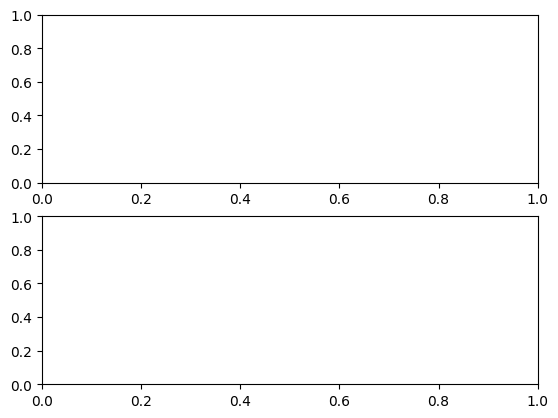

In [157]:
fig, (ax1,ax2) = plt.subplots(2,1)

In [158]:
obs = wrap_env.reset()
print(wrap_env.get_attr("internal_state"))
start_cost = wrap_env.get_attr("last_cost")[0]
rewards = []
mhc = []
images = []
gain = 0
gains = []
actions = []
done = False

[array([ 2,  1,  4,  5, 10,  1,  8,  9, 10, 19,  5,  6,  2, 11,  4,  6, 18,
       20,  4,  4,  1, 21,  3,  5], dtype=uint8)]


In [159]:
while done != True:

    action, _states = model.predict(obs, deterministic = True)
    actions.append(action)
    obs, reward, done, info = wrap_env.step(action)
    gain += reward
    img =  wrap_env.render(mode='rgb_array')
    rewards.append(reward)
    mhc.append(info[0]['mhc'])
    gains.append(gain)
    images.append(img)

In [160]:
final_cost = mhc[-1]
cost_saved = final_cost-start_cost
cost_saved_rel = 1-(start_cost/final_cost)
ax1.plot(rewards)
ax2.plot(mhc)
#imageio.mimsave(f'gifs/{save_path}_test_env.gif', [np.array(img.resize((200,200),Image.NEAREST)) for i, img in enumerate(images) if i%2 == 0], fps=29)

In [161]:
vec_eval_env.close()
del model

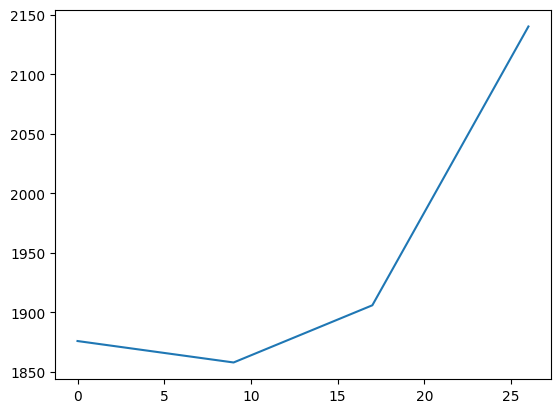

In [162]:
plt.plot(mhc)